In [1]:
import pandas as pd
import numpy as np
import dask.array as da
import dask.dataframe as dd
import time
import math
#import graphviz
from netCDF4 import Dataset
import os,datetime,sys,fnmatch
import h5py

In [2]:
def read_filelist(loc_dir,prefix,unie,fileformat):
    # Read the filelist in the specific directory
    str = os.popen("ls "+ loc_dir + prefix + unie + "*."+fileformat).read()
    fname = np.array(str.split("\n"))
    fname = np.delete(fname,len(fname)-1)
    
    return fname

def read_MODIS(fname1,fname2,verbose=False): # READ THE HDF FILE
    # Read the cloud mask from MYD06_L2 product')
    ncfile=Dataset(fname1,'r')
    CM1km = np.array(ncfile.variables['Cloud_Mask_1km'])
    CM   = (np.array(CM1km[:,:,0],dtype='byte') & 0b00000110) >>1
    #ncfile = Dataset(fname1, "r")
    #CM = myd06.variables["Cloud_Mask_1km"][:,:,:] # Reading Specific Variable 'Cloud_Mask_1km'.
    #CM   = (np.array(CM[:,:,0],dtype='byte') & 0b00000110) >>1
    ncfile.close()
    
    ncfile=Dataset(fname2,'r')
    lat  = np.array(ncfile.variables['Latitude'])
    lon  = np.array(ncfile.variables['Longitude'])
    #ncfile = Dataset(MOD03_files, "r")
    #latitude = myd03.variables["Latitude"][:,:] # Reading Specific Variable 'Latitude'.
    #latitude = np.array(latitude).byteswap().newbyteorder() # Addressing Byteswap For Big Endian Error.
    #longitude = myd03.variables["Longitude"][:,:] # Reading Specific Variable 'Longitude'.
    attr_lat = ncfile.variables['Latitude']._FillValue
    attr_lon = ncfile.variables['Longitude']._FillValue
    """#Use _FillValue to remove fill data in lat & lon
    lat[np.where(lat == attr_lat)] = 0.0
    lon[np.where(lat == attr_lat)] = 0.0
    CM [np.where(lat == attr_lat)] = 0.5 #which will not be identified by lines 80-83 
    lat[np.where(lon == attr_lon)] = 0.0
    lon[np.where(lon == attr_lon)] = 0.0
    CM [np.where(lon == attr_lon)] = 0.5 #which will not be identified by lines 80-83
    ncfile.close()"""
    return lat,lon,CM

In [3]:
def value_locate(refx, x):
    refx = np.array(refx)
    x = np.array(x)
    loc = np.zeros(len(x), dtype='int')
    
    for i in np.arange(len(x)):
        ix = x[i]
        ind = ((refx - ix) <= 0).nonzero()[0]
        if len(ind) == 0:
            loc[i] = -1
        else: loc[i] = ind[-1]

    return loc

def division(n, d):

    div = np.zeros(len(d))
    for i in range(len(d)):
        if d[i] >0:
          div[i]=n[i]/d[i]
        else: div[i]=None 

    return div

def countzero(x, axis=1):
    #print(x)
    count0 = 0
    count1 = 0
    for i in x:
        if i <= 1:
            count0 +=1
    #print(count0/len(x))
    return (count0/len(x))

satellite = 'Aqua'

yr = [2008]
mn = [1] #np.arange(1,13)  #[1]
dy = [1] #np.arange(1,32) # [1] #np.arange(1,31)
lat_bnd = np.arange(-90,91,1)# latitude and longtitude boundaries of level-3 grid
lon_bnd = np.arange(-180,180,1)
nlat = 180
nlon = 360

TOT_pix      = np.zeros(nlat*nlon)
CLD_pix      = np.zeros(nlat*nlon)

In [15]:
MYD06_dir= '/Users/dprakas1/Desktop/modis_oneday/'
MYD06_prefix = 'MYD06_L2.A2008'
MYD03_dir= '/Users/dprakas1/Desktop/modis_oneday/'
MYD03_prefix = 'MYD03.A2008'
fileformat = 'hdf'

fname1,fname2 = [],[]


days = np.arange(1,31,dtype=np.int)
for day in days:
    dc ='%03i' % day
    fname_tmp1 = read_filelist(MYD06_dir,MYD06_prefix,dc,fileformat)
    fname_tmp2 = read_filelist(MYD03_dir,MYD03_prefix,dc,fileformat)
    fname1 = np.append(fname1,fname_tmp1)
    fname2 = np.append(fname2,fname_tmp2)

# Initiate the number of day and total cloud fraction
files  = np.arange(len(fname1))



for j in range(0,1):#hdfs:
    print('steps: ',j+1,'/ ',(fname1)) 

    # Read Level-2 MODIS data
    lat,lon,CM = read_MODIS(fname1[j],fname2[j])
print((fname2))
#rint(CM)
#lat = lat.ravel()
#lon = lon.ravel()
#CM  = CM.ravel()
CM.shape

steps:  1 /  ['/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0000.006.2013341193524.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0005.006.2013341193207.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0010.006.2013341192125.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0015.006.2013341193150.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0020.006.2013341193235.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0025.006.2013341192801.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0030.006.2013341193002.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0035.006.2013341193634.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0040.006.2013341200201.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0045.006.2013341200648.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0050.006.2013341205630.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A200

['/Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0000.006.2012066122450.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0005.006.2012066122516.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0010.006.2012066122416.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0015.006.2012066122424.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0020.006.2012066122516.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0025.006.2012066122634.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0030.006.2012066125916.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0035.006.2012066130550.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0040.006.2012201150018.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0045.006.2012201144820.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0050.006.2012201144257.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0055.006.2012066122702.hdf'
 '/Users/dprakas

(2030, 1354)

In [16]:
combs=[]
for x in range(-89,91):
    for y in range(-179,181):
        combs.append((x, y))
df_1=pd.DataFrame(combs)
df_1.columns=['Latitude','Longitude']

In [17]:
b1=[]
cloud_pix = np.zeros((180, 360))
for x,y in zip(fname1,fname2):
    cm = np.zeros((2030,1354), dtype=np.float32)
    lat = np.zeros((2030,1354), dtype=np.float32)
    lon = np.zeros((2030,1354), dtype=np.float32)
    print(x,y)
    myd06 = Dataset(x, "r")
    CM = myd06.variables["Cloud_Mask_1km"][:,:,0]# Reading Specific Variable 'Cloud_Mask_1km'.
    CM = (np.array(CM,dtype='byte') & 0b00000110) >>1
    CM = np.array(CM).byteswap().newbyteorder()
    print("CM intial shape:",CM.shape)
    cm = np.concatenate((cm,CM))
    #print("CM shape after con:",cm.shape)
    cm=np.ravel(cm)
    print("cm shape after ravel:",cm.shape)
    myd03 = Dataset(y, "r")
    latitude = myd03.variables["Latitude"][:,:]
    longitude = myd03.variables["Longitude"][:,:]
    print("Lat intial shape:",latitude.shape)
    print("lon intial shape:",longitude.shape)
    
    
    lat = np.concatenate((lat,latitude))
    lon = np.concatenate((lon,longitude))
    print("lat shape after con:",lat.shape)
    print("lon shape after con:",lon.shape)
    
    lat=np.ravel(lat)
    lon=np.ravel(lon)
    
    print("lat shape after ravel:",lat.shape)
    print("lon shape after ravel:",lon.shape)
    cm=cm.astype(int)
    lon=lon.astype(int)
    lat=lat.astype(int)
    #print(lat,lon)
    d = {'Latitude' :  pd.Series(lat), 'Longitude' : pd.Series(lon),'CM':pd.Series(cm)} #Reading the values in a pandas dataframe
    df = pd.DataFrame(d,columns=['Latitude', 'Longitude','CM'])
    #print(df.head())
    df2=df.groupby(['Longitude','Latitude']).CM.apply(countzero)
    df3=df2.reset_index()
    #df3[['CLD_pix','TOT_pix']]=pd.DataFrame(df3['CM'].tolist(),index=df3.index)
    #print(df3.head())
    #CF=pd.DataFrame(df3['CLD_pix']/df3['TOT_pix'])
    #print(CF)
    
    df4=pd.merge(df_1, df3,on=('Longitude','Latitude'), how='left')
    
    #df5=df4.fillna(0)
    #print(df5.head())
    
    b1.append(df4['CM'])
    
    #print(df2)
    #print(b1)

/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0000.006.2013341193524.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0000.006.2012066122450.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0005.006.2013341193207.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0005.006.2012066122516.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0010.006.2013341192125.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0010.006.2012066122416

Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0140.006.2013341192718.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0140.006.2012066122621.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0145.006.2013341192825.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0145.006.2012066122649.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (54

/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0315.006.2013341193227.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0315.006.2012066122653.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0320.006.2013341193800.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0320.006.2012066122620.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0325.006.2013341193453.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0325.006.2012066122531

lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0455.006.2013341194150.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0455.006.2012066122844.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0500.006.2013341194241.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0500.006.2012066122614.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desk

CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0635.006.2013341201326.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0635.006.2012066122457.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0640.006.2013341200819.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0640.006.2012066122401.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 135

/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0810.006.2013341194035.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0810.006.2012066123443.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0815.006.2013341193800.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0815.006.2012066123116.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0820.006.2013341193731.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0820.006.2012066125836

Lat intial shape: (2040, 1354)
lon intial shape: (2040, 1354)
lat shape after con: (4070, 1354)
lon shape after con: (4070, 1354)
lat shape after ravel: (5510780,)
lon shape after ravel: (5510780,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0950.006.2013341193942.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0950.006.2012066122947.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0955.006.2013341194638.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.0955.006.2012066132015.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (54

/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1125.006.2013341194755.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1125.006.2012066125957.hdf
CM intial shape: (2040, 1354)
cm shape after ravel: (5510780,)
Lat intial shape: (2040, 1354)
lon intial shape: (2040, 1354)
lat shape after con: (4070, 1354)
lon shape after con: (4070, 1354)
lat shape after ravel: (5510780,)
lon shape after ravel: (5510780,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1130.006.2013341194353.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1130.006.2012066131907.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1135.006.2013341195343.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1135.006.2012066132049

Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1305.006.2013341212013.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1305.006.2012066124221.hdf
CM intial shape: (2040, 1354)
cm shape after ravel: (5510780,)
Lat intial shape: (2040, 1354)
lon intial shape: (2040, 1354)
lat shape after con: (4070, 1354)
lon shape after con: (4070, 1354)
lat shape after ravel: (5510780,)
lon shape after ravel: (5510780,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1310.006.2013341193744.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1310.006.2012066122950.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (54

/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1440.006.2013341201342.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1440.006.2012066124757.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1445.006.2013341200222.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1445.006.2012066123549.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1450.006.2013341194734.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1450.006.2012066123251

Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1620.006.2013341200150.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1620.006.2012066125803.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1625.006.2013341194050.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1625.006.2012066124800.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (54

/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1755.006.2013341195226.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1755.006.2012066125148.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1800.006.2013341194444.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1800.006.2012066125432.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1805.006.2013341200432.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1805.006.2012066125249

Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1935.006.2013341194750.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1935.006.2012066125032.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.1940.006.2013341194211.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.1940.006.2012066125510.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (54

/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.2110.006.2013341202040.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.2110.006.2012066125444.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.2115.006.2013341194539.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.2115.006.2012066125838.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.2120.006.2013341201517.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.2120.006.2012066125818

Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.2250.006.2013341201332.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.2250.006.2012066132414.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.2255.006.2013341194729.hdf /Users/dprakas1/Desktop/modis_oneday/MYD03.A2008001.2255.006.2012066124244.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (54

In [18]:
x=pd.concat(b1,axis=1)
y=x.sum(axis=1)
y_ax=y.values


In [19]:
type(y_ax)
y_re=y_ax.reshape(180,360)
y_re

array([[13.02469742, 12.47939238, 12.54632678, ..., 12.78229085,
        13.07928201,  0.        ],
       [14.51897013, 14.54765379, 14.68039748, ..., 14.21217997,
        14.18246765,  0.        ],
       [14.67915654, 14.89175043, 14.92714323, ..., 14.55912674,
        14.59156826,  0.        ],
       ...,
       [12.67633854, 12.65101215, 12.64267543, ..., 12.58241758,
        12.68569712,  0.        ],
       [13.83333333, 13.97142857, 13.84375   , ..., 14.        ,
        13.76923077,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [20]:
total_cloud_fraction = y_re
out_name = '/Users/dprakas1/Desktop/y_reshape_full.hdf5'
def save_hdf(out_name,total_cloud_fraction,lat_bnd,lon_bnd):
    f=h5py.File(out_name,'w')
    PCentry=f.create_dataset('CF',data=total_cloud_fraction)
    PCentry.dims[0].label='lat_bnd'
    #PCentry.dims[1].label='lon_bnd'

    PC=f.create_dataset('lat_bnd',data=lat_bnd)
    PC.attrs['units']='degrees'
    PC.attrs['long_name']='Latitude_boundaries'

    PC=f.create_dataset('lon_bnd',data=lon_bnd)
    PC.attrs['units']='degrees'
    PC.attrs['long_name']='Longitude_boundaries'
    f.close()
    print(out_name+' Saved!!')

save_hdf(out_name,total_cloud_fraction,lat_bnd,lon_bnd)

/Users/dprakas1/Desktop/y_reshape_full.hdf5 Saved!!


Maximum absolute bias:0.0000
Minimum absolute bias:0.0000


/Users/dprakas1/Documents/comparisons.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/Users/dprakas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


AttributeError: 'str' object has no attribute 'show'

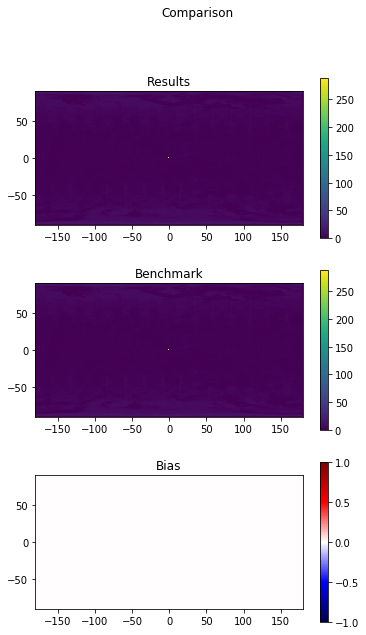

In [27]:
import h5py
import numpy as np
from comparisons import readData, doPlot
#benchmark_p="/Users/dprakas1/Documents/"
#CF_BMK,_,_=readData(benchmark_p+"MODAgg_3var_parMonth_20080101.hdf5")#Benchmark

f=h5py.File('/Users/dprakas1/Desktop/y_reshape_full.hdf5','r')
CF_res=f['CF'][:]
fig1,fig2=doPlot(CF_res,CF_res,'Comparison')

fig1.show()
fig2.show()

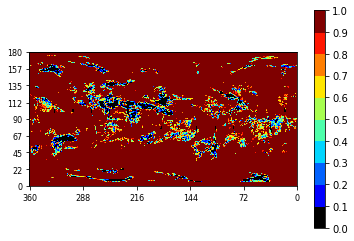

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import calendar
import pprint
data = y_re

data_shape = data.shape

cmap = [(0.0,0.0,0.0)] + [(cm.jet(i)) for i in range(1,256)] 
cmap = mpl.colors.ListedColormap(cmap)

bounds = [0.0, 0.1, 0.2 , 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

img = plt.imshow(np.fliplr(data), cmap=cmap, norm=norm,
                  interpolation='none', origin='lower')

cbar_bounds = [0.0, 0.1, 0.2 , 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cbar_ticks = [0.0, 0.1, 0.2 , 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]             
               
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=cbar_bounds, ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticks, fontsize=10)

l = [int(i) for i in np.linspace(0,data_shape[1],6)]
plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=8 )

l = [int(i) for i in np.linspace(0,data_shape[0],9)]
plt.yticks(l, l, rotation=0, fontsize=8 )

title = 'Cloud Fraction \n MYD06 C6 ({}-{:02d}-{:02d}; {:02d}h{:02d})'
#plt.title(title.format( year, month, day, hh, mm), fontsize=10)
plt.show()

In [30]:
plt.savefig('rename')

<Figure size 432x288 with 0 Axes>